## 01. Import Libraries and Data

In [1]:
# Import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Set path
path = r'C:\Users\jeong\OneDrive\Desktop\CF Files\Achievement 6'

In [3]:
# Import data
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'food_surplus_cleaned.csv'))

In [4]:
# Check data
df.head()

,Unnamed: 0,year,state,sector,sub_sector,sub_sector_category,food_type,tons_surplus,tons_supply,us_dollars_surplus,...,tons_incinerated,tons_land_application,tons_landfilled,tons_sewer,tons_refuse_discards,upstream_mtco2e_footprint,downstream_mtco2e_footprint,total_mtco2e_footprint,gallons_water_footprint,meals_wasted
0,0,2021,Alabama,Farm,Not Applicable,Not Applicable,Dry Goods,8314.881697,320214.881700,3.883810e+06,...,0.000000,0.0,0.000000,0.0,0.000000,34693.574640,2.560352,34696.134990,4.676082e+09,1.385814e+07
1,1,2021,Alabama,Farm,Not Applicable,Not Applicable,Produce,56169.900990,216424.760100,1.586598e+07,...,13.232212,0.0,354.329224,0.0,688.009528,11481.349950,2256.026644,13737.376590,1.828809e+09,9.289640e+07
2,2,2021,Alabama,Foodservice,Bars And Taverns,Bars And Taverns,Breads & Bakery,5.014448,188.451867,2.527011e+04,...,0.178206,0.0,4.771954,0.0,0.000000,11.966534,7.289450,19.255983,9.666914e+04,8.269175e+03
3,3,2021,Alabama,Foodservice,Bars And Taverns,Bars And Taverns,Dairy & Eggs,2.385432,89.648781,1.279831e+04,...,0.084775,0.0,2.270075,0.0,0.000000,11.419306,1.124870,12.544176,6.806127e+05,3.933744e+03
4,4,2021,Alabama,Foodservice,Bars And Taverns,Bars And Taverns,Dry Goods,4.263947,160.246725,1.471922e+04,...,0.151534,0.0,4.057747,0.0,0.000000,13.478114,4.155081,17.633195,5.264528e+05,7.031547e+03


In [5]:
# Check shape
df.shape

(173364, 31)

## 02. Subsetting, Wrangling, and Cleaning Time-Series Data

In [6]:
df = df.drop(columns= ['Unnamed: 0'])

In [7]:
# Create subset of avg us_dollars_surplus and total_mtco2e_footprint
data = df.groupby('year', as_index = False)[['us_dollars_surplus', 'total_mtco2e_footprint']].mean()

In [8]:
data.head()

,year,us_dollars_surplus,total_mtco2e_footprint
0,2010,2.299512e+07,21043.353394
1,2011,2.401676e+07,21944.120843
2,2012,2.474948e+07,22366.244463
3,2013,2.582941e+07,23176.114042
4,2014,2.657987e+07,23795.504281


In [9]:
# Create subset to be used in time series analysis
df_sub = data[['year', 'us_dollars_surplus']]

In [10]:
# Create a datetime column from "year"
# Set "year" column as the index of the subset
from datetime import date

df_sub['datetime'] = pd.to_datetime(df_sub['year'], format = '%Y')
df_sub = df_sub.set_index('datetime')
df_sub.drop(['year'], axis=1, inplace = True)
df_sub.head()

,us_dollars_surplus
datetime,
2010-01-01,2.299512e+07
2011-01-01,2.401676e+07
2012-01-01,2.474948e+07
2013-01-01,2.582941e+07
2014-01-01,2.657987e+07


I chose these data points because the data analysis of this dataset revolves around food surplus. As well as, the different methods of discarding the excess food and the environmental impact as a result. Therefore, I was deciding between tons_surplus and us_dollars_surplus, to see the changes in surplus or changes in the dollar value of surplus throughout the years . From the two variables, us_dollars_surplus had higher correlation with more of the environmental variables and it also shows the economical impact of food surplus overtime. As of a result I created a subset with us_dollars_surplus to perform a time series analysis.

## 03. Create line chart of the data

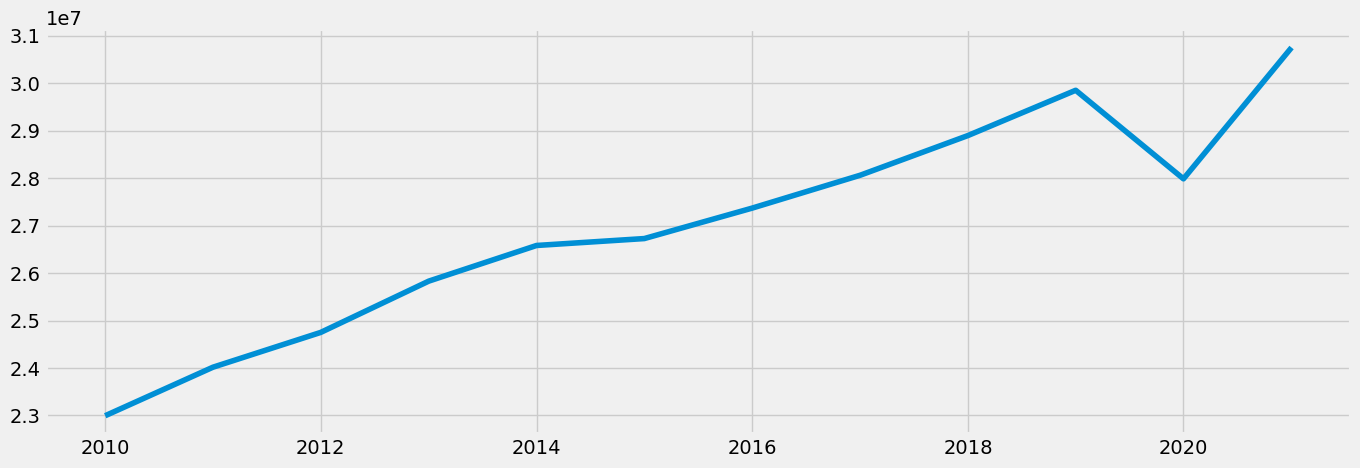

In [11]:
# PLot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

## 04. Time Series Analysis - Decomposition

In [12]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive')

In [13]:
from pylab import rcParams

rcParams['figure.figsize'] = (18,7)

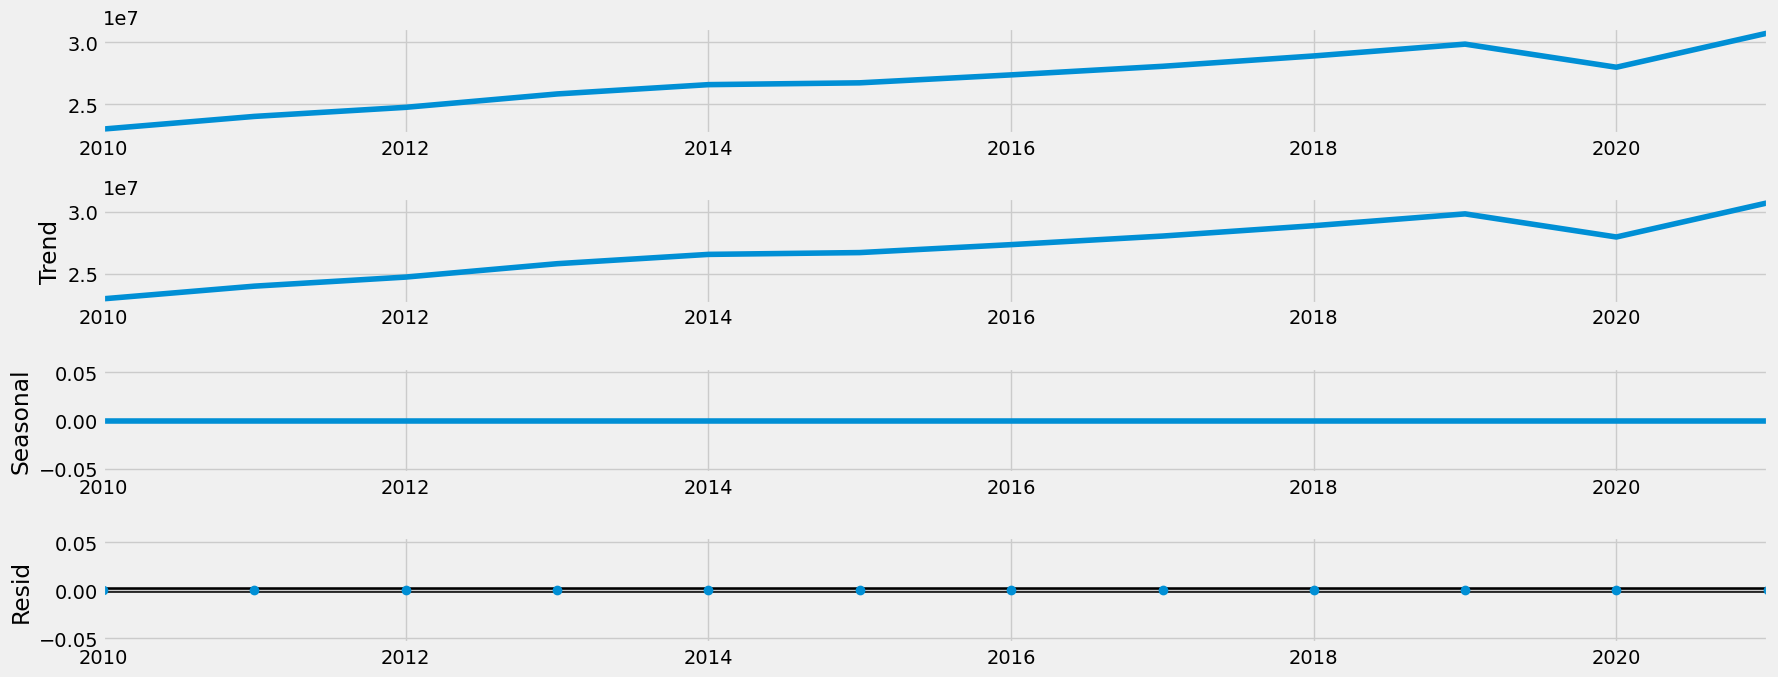

In [14]:
# Plot the separate components
decomposition.plot()
plt.show()

#### Observations <br>

* trend: positive/upward trend <br>
* seasonality: no observable seasonality <br>
* noise: no observable noise <br>

Data seems to be non-stationary because there is an upward trend.

## 05. Testing for Stationarity

In [15]:
# Import the adfuller() function, it will import from the model from statsmodels for the test
# Define a function that prints the correct output from the array returned from adfuller()
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print(result)
    
dickey_fuller(df_sub['us_dollars_surplus'])

Dickey-Fuller Stationarity test:
Test Statistic                -2.770778
p-value                        0.062571
Number of Lags Used            4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


#### Observations <br>

* test statistic = -2.770778 > critical value (5%) = -3.477583

The test statistic is larger than the critical value at all significance levels. Additionally, p-value > 0.05. Therefore, the null hypothesis, there is no relationship between amount of food surplus in terms of US Dollars in a state and the co2 emissions from that state is not rejected. This means that there is a unit root in the data. As a result, the data is non-stationary

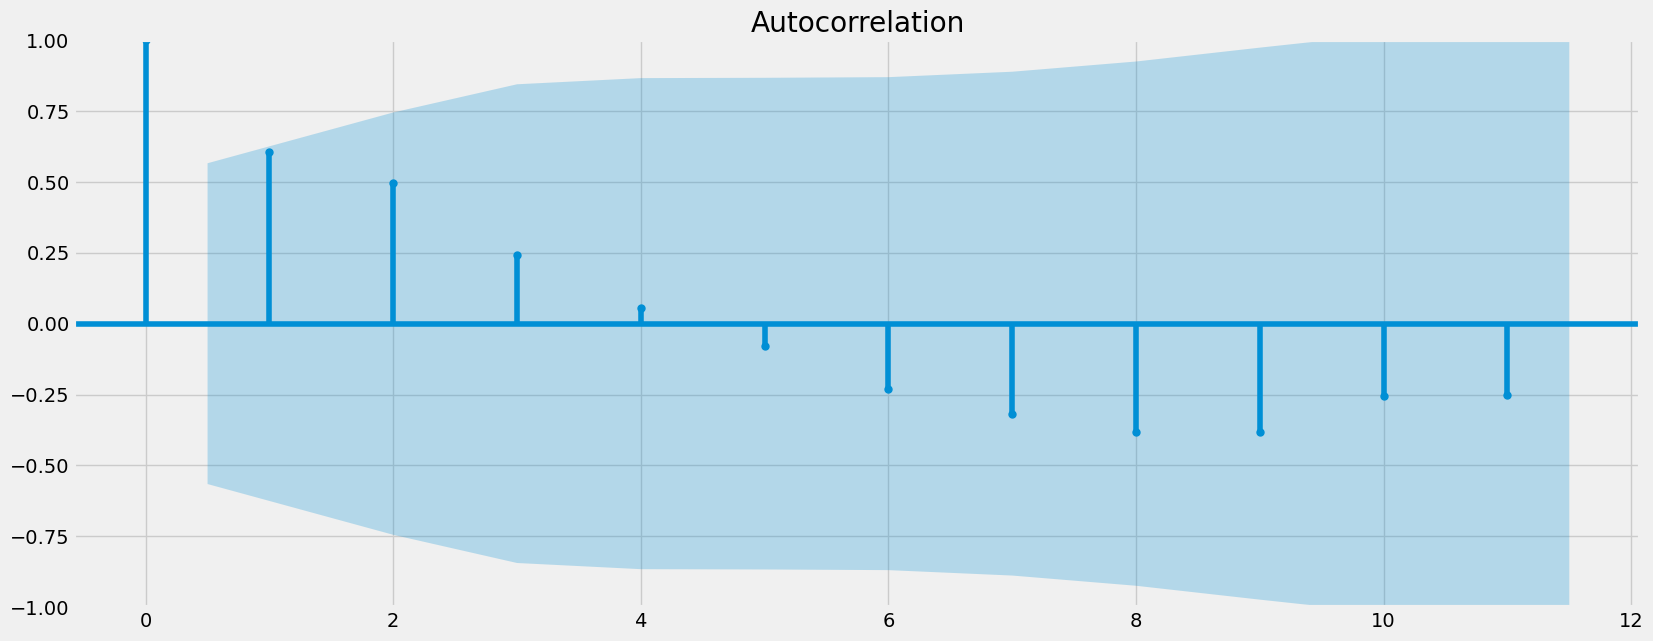

In [16]:
# Create a plt of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_sub)
plt.show()

## 06. Stationarizing Data

In [17]:
df_diff = df_sub - df_sub.shift(1)

In [18]:
df_diff.dropna(inplace = True)

In [19]:
df_diff.head()

,us_dollars_surplus
datetime,
2011-01-01,1.021641e+06
2012-01-01,7.327211e+05
2013-01-01,1.079935e+06
2014-01-01,7.504559e+05
2015-01-01,1.456084e+05


In [20]:
df_diff.columns

Index(['us_dollars_surplus'], dtype='object')

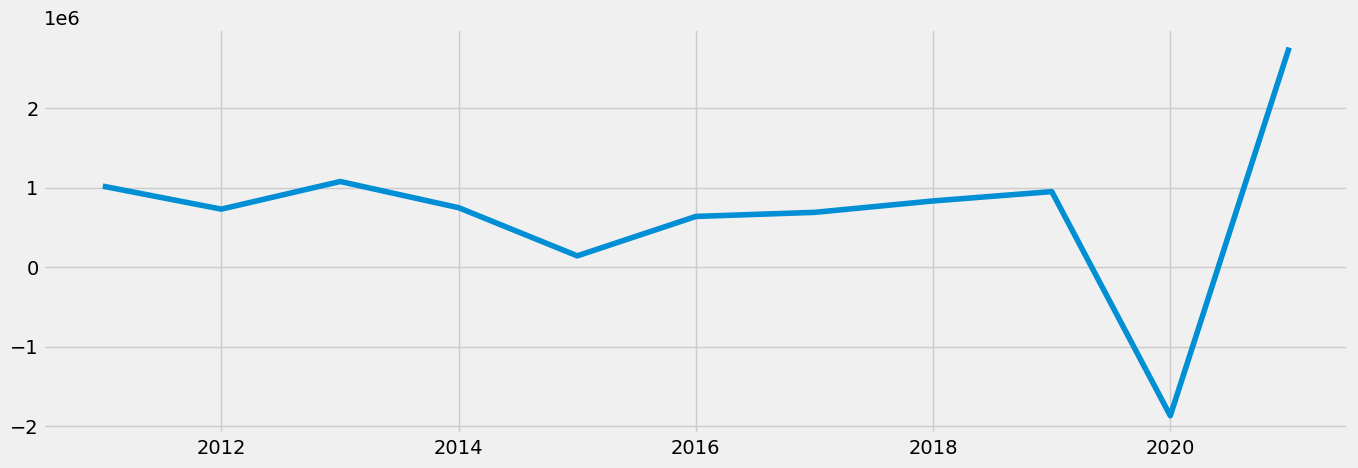

In [21]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi = 100)
plt.plot(df_diff)

In [22]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -5.523322
p-value                         0.000002
Number of Lags Used             0.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


#### Observations <br>

* test statistic = -5.523322 < critical value (5%) = -3.232950

The test statistics is smaller than the critical value at all significance levels. Additionally, the p-value is very small (p < 0.05). Therefore, we reject the null hypothesis, the series is stationary.

## 07. Check autocorrelations

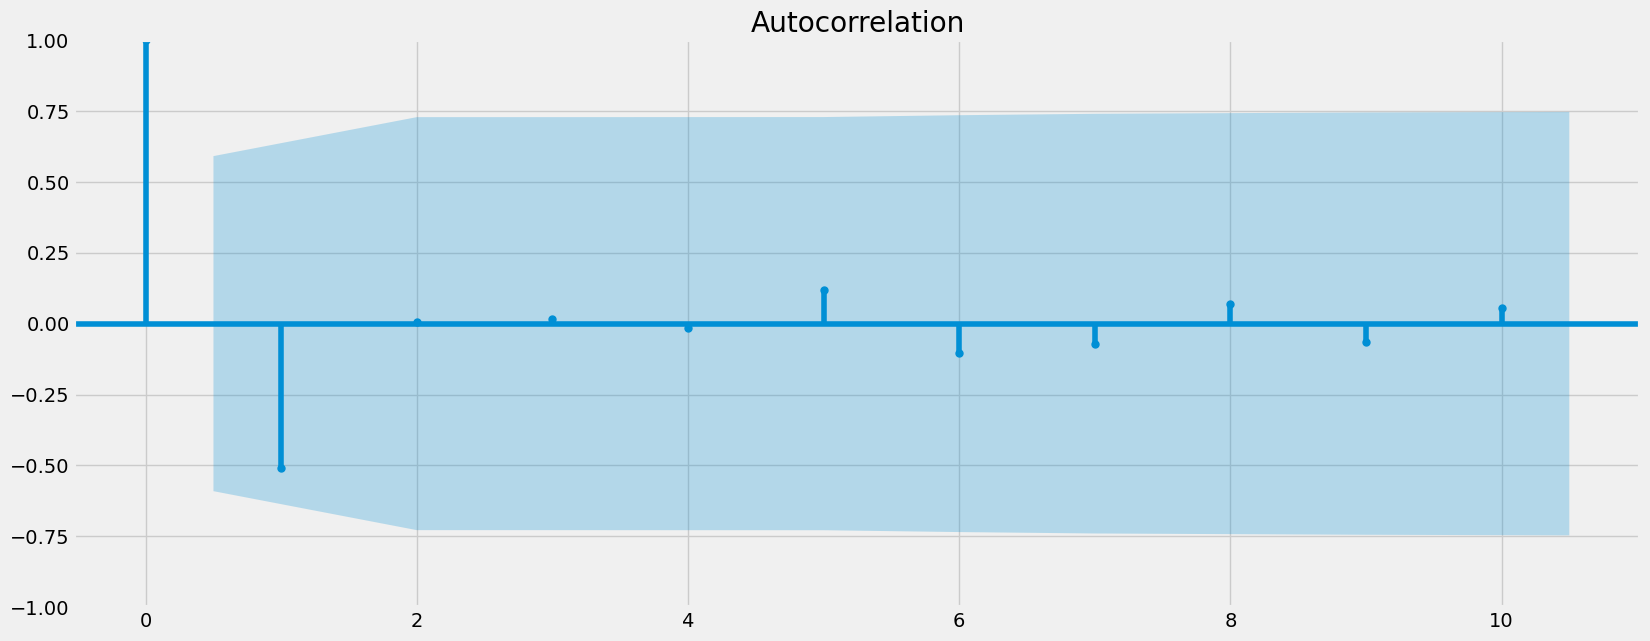

In [23]:
# Create a plt of autocorrelations
plot_acf(df_diff)
plt.show()

There is only one significant lag abouve the confidence interval, no further differencing to stationarize is required.

# Bonus Task

## 08. Defining Parameters


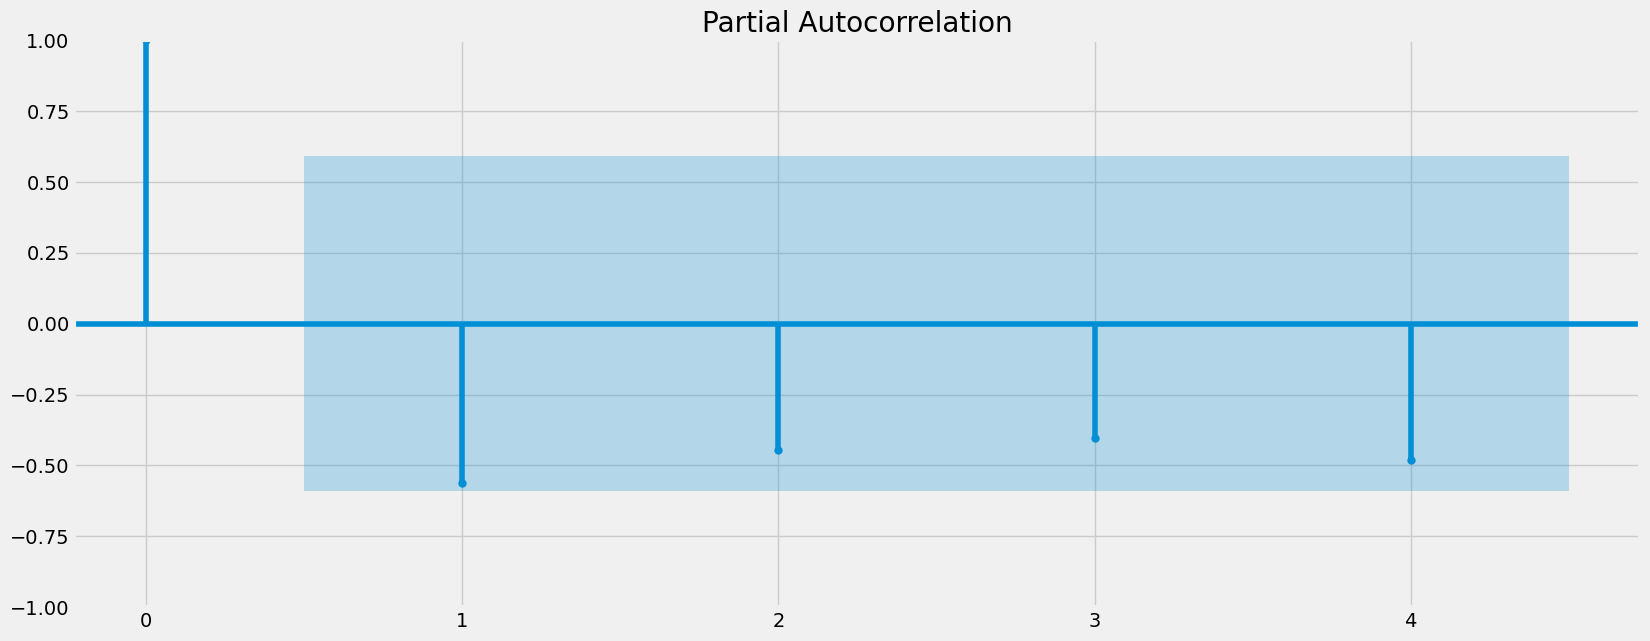

<Figure size 4500x4500 with 0 Axes>

In [24]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(df_diff, lags=4)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

There is only highly positive bar. p = 1

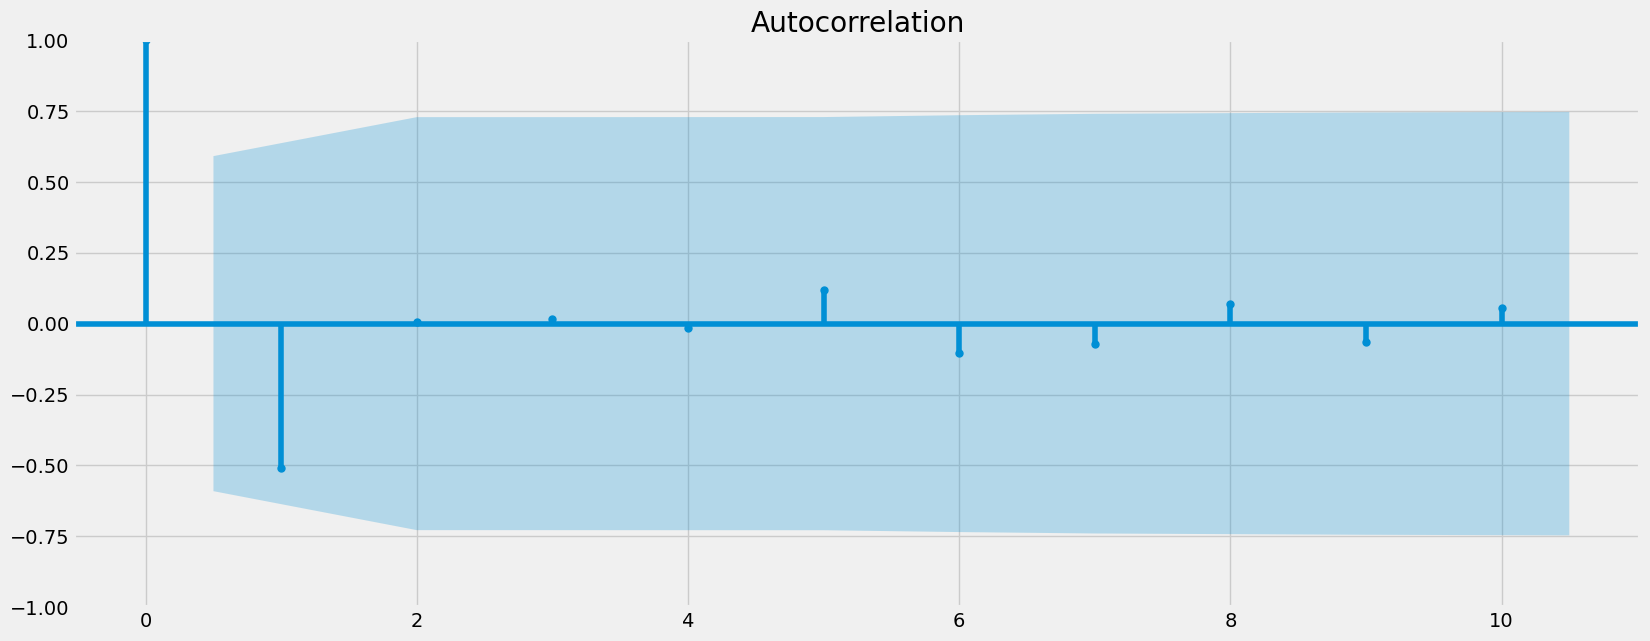

<Figure size 1500x500 with 0 Axes>

In [25]:
# PLot autocorrectoins to determine parameter q
plot_acf(df_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

There is only one significant autocorrelation, q = 1

## 09. Splitting the Data

In [26]:
# Split the data
# Data was split ~ 80/20
train = df_diff['us_dollars_surplus'][:10]
test = df_diff['us_dollars_surplus'][9:]

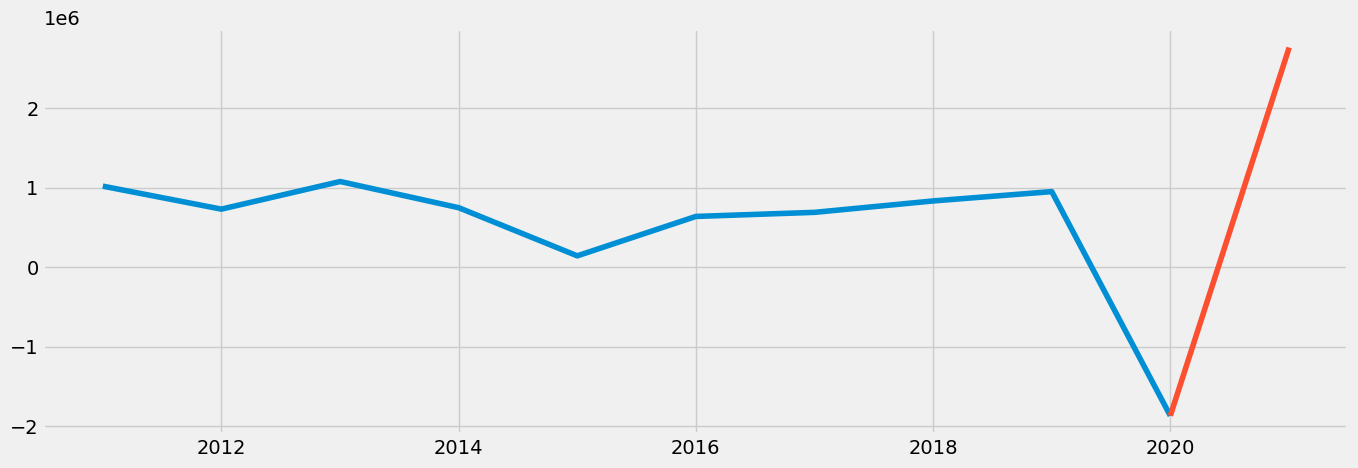

In [27]:
# Plot both sets in order to see the split
plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [28]:
test.shape

(2,)

## 10. Running and Fitting the Model

In [29]:
from statsmodels.tsa.api import ARIMA # Import the model you need

                               SARIMAX Results                                
Dep. Variable:     us_dollars_surplus   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -137.007
Date:                Sun, 24 Sep 2023   AIC                            280.014
Time:                        15:31:36   BIC                            280.606
Sample:                    01-01-2011   HQIC                           278.737
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2577      5.489     -0.047      0.963     -11.016      10.500
ma.L1         -0.6552      3.124     -0.210      0.834      -6.779       5.468
sigma2      1.419e+12   1.04e-11   1.36e+23      0.0

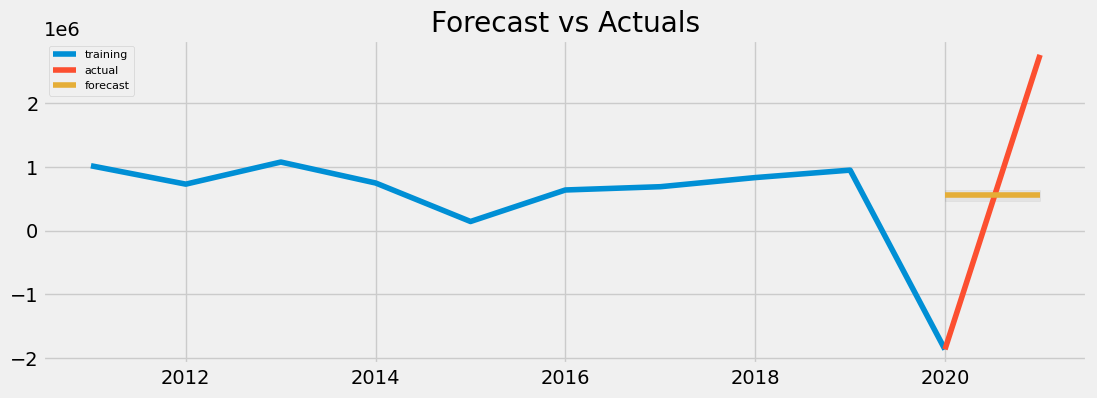

In [30]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary()) 
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(fc - conf, index=test.index) 
upper_series = pd.Series(fc + conf, index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) 
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

* Model summary shows result of AR is insignificant (p = 0.629 > 0.05)
* Result of MA is significant (p = 0.045 < 0.05)
* On the plot, the actual curve falls outside of the forecasted confidence interval

                               SARIMAX Results                                
Dep. Variable:     us_dollars_surplus   No. Observations:                   10
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -137.009
Date:                Sun, 24 Sep 2023   AIC                            282.017
Time:                        15:31:36   BIC                            282.806
Sample:                    01-01-2011   HQIC                           280.315
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2730      9.555     -0.029      0.977     -19.000      18.454
ar.L2         -0.0390      9.070     -0.004      0.997     -17.816      17.738
ma.L1         -0.6411      9.774     -0.066      0.9

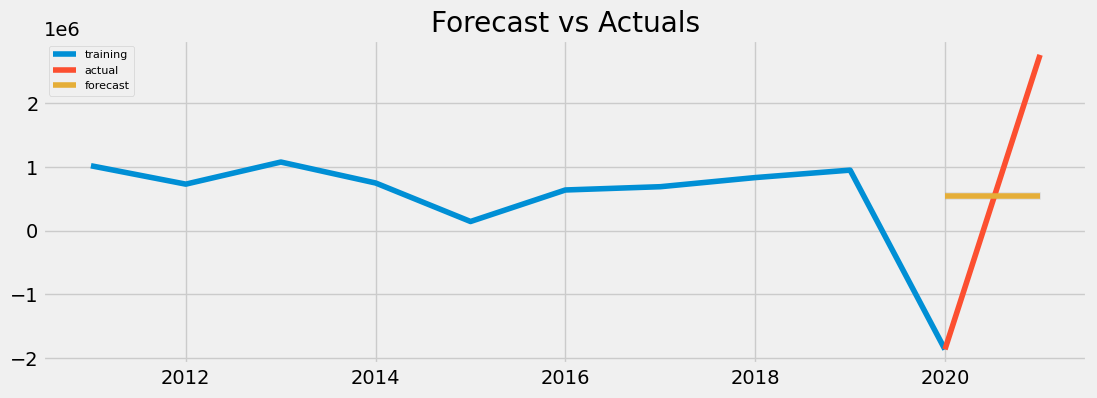

In [31]:
model = ARIMA(train, order=(2, 1, 1)) 
fitted = model.fit()  
print(fitted.summary()) 
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(fc - conf, index=test.index) 
upper_series = pd.Series(fc + conf, index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) 
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

10+ iterations were run, non seem to produce a model that fits well. The closest one was the one above, with the AR term increased, the result of one of the AR becomes significant, however, the result of MA becomes insignificant. Any other changes in the parameters resulted in all of the terms becoming insignificant and the model performing worse.